In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..','..','..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 20,'legend.fontsize':20})
import ursse.path_assistant as pa
shift = pa.PathAssistant('shift_02_28_2020')
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec
from ursse.time_structure import get_bucket_gates, get_rate_in_gate_Hz,get_dfs_for_all_buckets

In [27]:
df, n_revolutions = read_event_delays(shift.get_time_stamp_file_path('1el_002.ptu'))
t_delays = df.delay

In [28]:
gate = (61000, 66000)
dt=0.1  # sec
revolutions_per_dt = dt/iota_period_sec

In [29]:
n = 500
i = 200

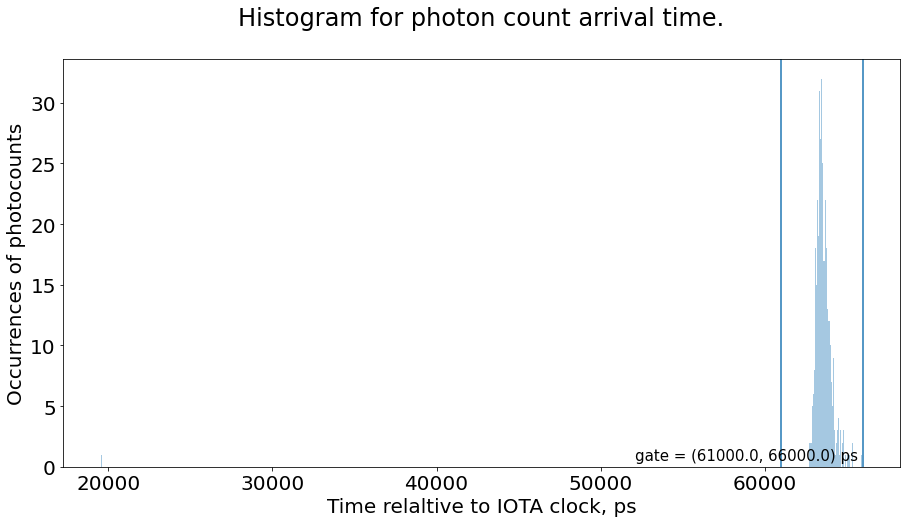

In [30]:
plot_arrival_time_hist(t_delays[i*n:(i+1)*n], gate=gate, bins=1000, yscale='linear')

In [31]:
df0 = get_dfs_for_all_buckets(df, gate)[0]
df0

,revolution,delay
51,51,62977.0
172,171,64337.0
241,239,62389.0
601,598,63454.0
1004,999,64303.0
...,...,...
452639788,450123392,63592.0
452640074,450123677,62846.0
452640278,450123880,62373.0
452640330,450123931,62842.0


In [32]:
len(df0.index)

1480026

In [33]:
events = get_events_array(df, n_revolutions, gate)

In [34]:
time_window_revolutions = 1000
n_of_time_windows = int(n_revolutions/time_window_revolutions)
new_events_len = time_window_revolutions*n_of_time_windows
events_in_time_windows = events[:new_events_len].reshape((-1, time_window_revolutions))

In [35]:
counts = np.sum(events_in_time_windows, axis=1)
counts_min = np.min(counts)
counts_max = np.max(counts)

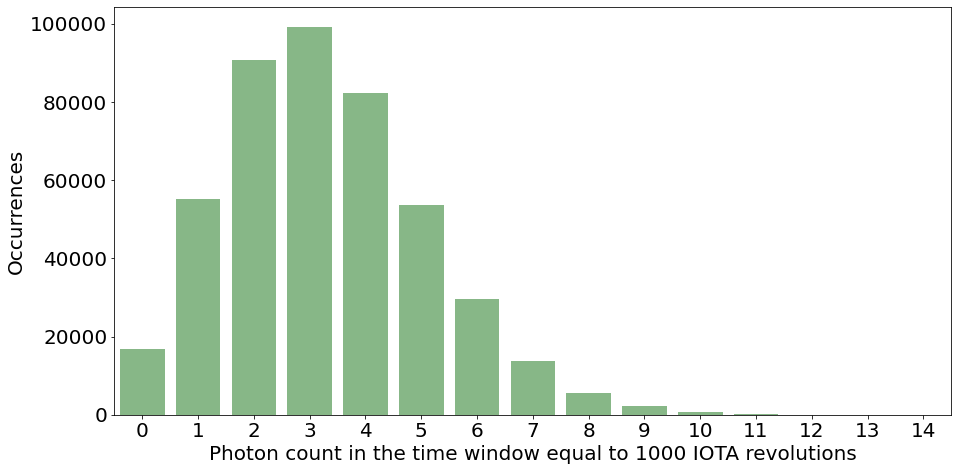

In [36]:
occurrences, _ = np.histogram(counts, bins=np.arange(counts_min - 0.5, counts_max + 0.5, 1))
fig, ax = plt.subplots()
sns.barplot(np.arange(counts_min, counts_max, dtype=int), occurrences, color='g', alpha=0.5, ax=ax)
ax.set_ylabel('Occurrences')
ax.set_xlabel(f'Photon count in the time window equal to {time_window_revolutions} IOTA revolutions')
plt.show()

In [37]:
p = len(df0.index)/n_revolutions
p

0.0032880375827290436

In [38]:
1/p

304.13277672149

In [39]:
from scipy.stats import chisquare
from scipy.special import factorial

In [40]:
lmda = time_window_revolutions*p
tot_counts = np.sum(occurrences)
counts_arr = np.arange(counts_min, counts_max)

In [41]:
counts_arr

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [42]:
occurrences_exp = tot_counts*lmda**counts_arr/factorial(counts_arr)*np.exp(-lmda)

In [43]:
statistic, pvalue = chisquare(occurrences, f_exp=occurrences_exp, ddof=2)

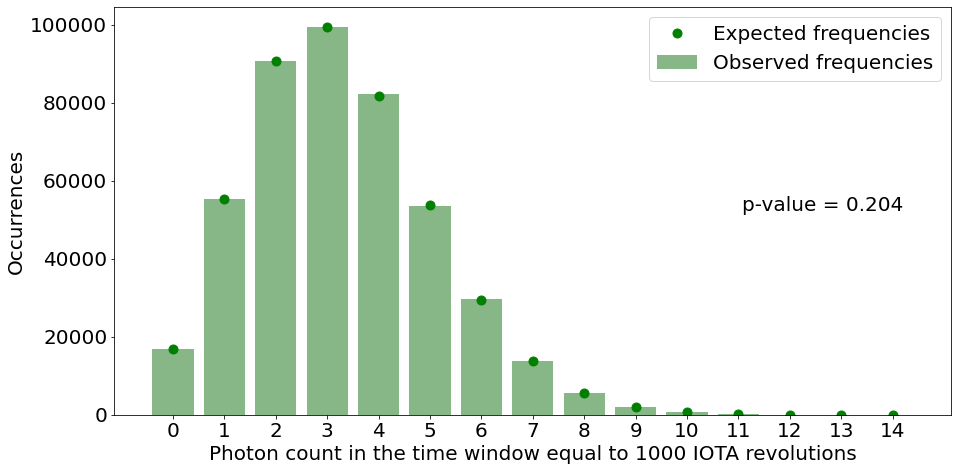

In [44]:
fig, ax = plt.subplots()
sns.barplot(np.arange(counts_min, counts_max, dtype=int), occurrences, color='g', alpha=0.5, ax=ax,
           label='Observed frequencies')
ax.plot(np.arange(counts_min, counts_max, dtype=int), occurrences_exp, 'go', markersize=9,
                label='Expected frequencies')
ax.set_ylabel('Occurrences')
ax.set_xlabel(f'Photon count in the time window equal to {time_window_revolutions} IOTA revolutions')
ax.text(0.75,0.5,f'p-value = {pvalue:.3f}',transform=ax.transAxes)
ax.legend()
plt.show()

In [45]:
inter_arrival_times = df0.diff()['revolution'].dropna().astype(int).values

In [46]:
inter_bin_len = 1
inter_df = pd.DataFrame({'inter_arrival_time': inter_arrival_times})
inter_df['inter_arrival_time_bin_idx'] = ((inter_df['inter_arrival_time']-1)/inter_bin_len).astype(int)
inter_df['inter_arrival_time_bin_time'] = inter_bin_len*inter_df['inter_arrival_time_bin_idx']
grouped = inter_df.groupby('inter_arrival_time_bin_idx')
res_df = pd.DataFrame({
    'inter_arrival_time_revolutions': grouped.inter_arrival_time_bin_time.mean().astype(int),
    'occurences': grouped.inter_arrival_time.count()})

In [47]:
import plotly.express as px
fig = px.line(x=res_df['inter_arrival_time_revolutions'], y=res_df['occurences'])
fig.show()

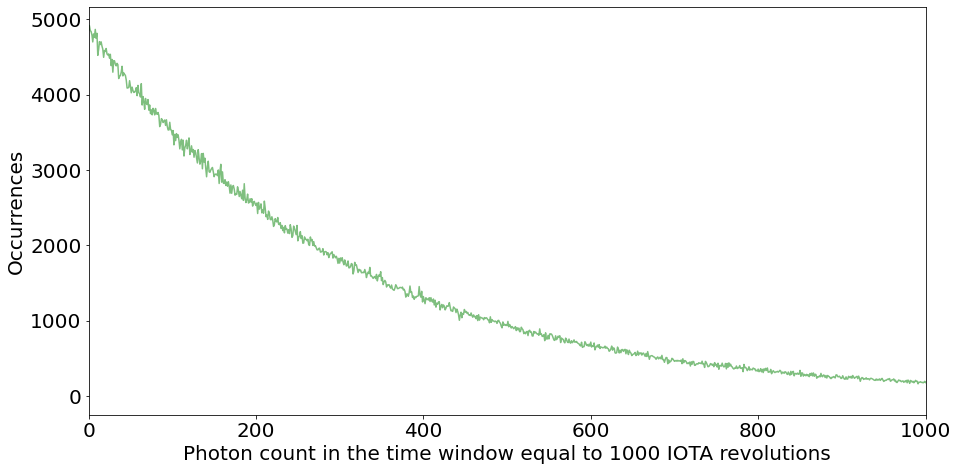

In [48]:
fig, ax = plt.subplots()
sns.lineplot(res_df['inter_arrival_time_revolutions'], res_df['occurences'], color='g', alpha=0.5, ax=ax)
ax.set_ylabel('Occurrences')
ax.set_xlabel(f'Photon count in the time window equal to {time_window_revolutions} IOTA revolutions')
ax.set_xlim(0,1000)
plt.show()

In [49]:
m = 3000
nmax = 1000
def get_Pr_n(m):
    return [np.sum(inter_arrival_times > m+n)/np.sum(inter_arrival_times > m) for n in range(1,nmax)]

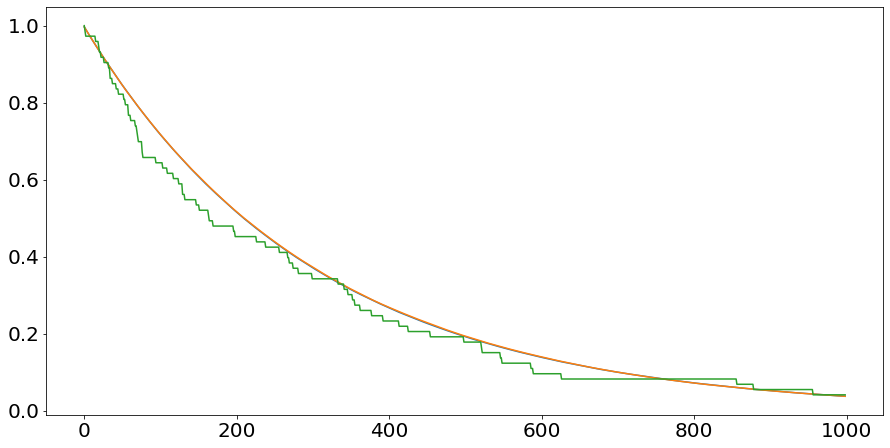

In [25]:
fig, ax = plt.subplots()
for m in [1, 300, 3000]:
    ax.plot(get_Pr_n(m))

In [26]:
(1-p)**n

0.1926794159531273